# Evaluating kinetics in FBA-gd

In [69]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import dill
import scipy

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

In [2]:
os.getcwd()

'/Users/cyrus/vivarium-ecoli'

# Import sim output

out/fbagd/kinetics_10_2022-08-22

In [62]:
time = '10'
date = '2022-09-22'
experiment = 'kinetics'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [63]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [64]:
f = open(folder + 'agent.pkl', 'rb')
agent = dill.load(f)
f.close()

In [65]:
s_matrix = agent['ecoli-metabolism-gradient-descent'].model.network.s_matrix
stoichiometry = agent['ecoli-metabolism-gradient-descent'].stoichiometry

In [67]:
s_matrix.shape

(3708, 4689)

In [7]:
fba.keys()

dict_keys(['reactionFluxes', 'estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'estimated_exchange_dmdt', 'target_kinetic_fluxes', 'target_kinetic_bounds'])

# Runtime, mass

In [10]:
times = [time - fba['time_per_step'][1] for time in fba['time_per_step'][1:]]
time_diff = [(times[i+1] - times[i])/2 for i in range(len(times)-1)]
index = [i for i in range(len(times)-1)]

KeyError: 'time_per_step'

In [11]:
# #f = sns.lineplot(index, time_diff)
# # f.hlines(y=[2,4], xmin=0, xmax=500)
# running_mean = np.convolve(time_diff, np.ones(10), 'valid') / 10
# f = sns.lineplot(index[0:len(running_mean)], running_mean)
# f.set_xlabel('Simulation step')
# f.set_ylabel('Real second to simulation second')

<AxesSubplot:>

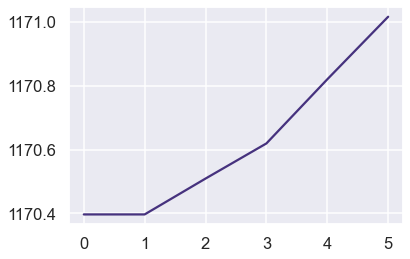

In [12]:
sns.lineplot(x=[i for i in range(len(mass['cell_mass']))],y=mass['cell_mass'])

# Molecule exchanges

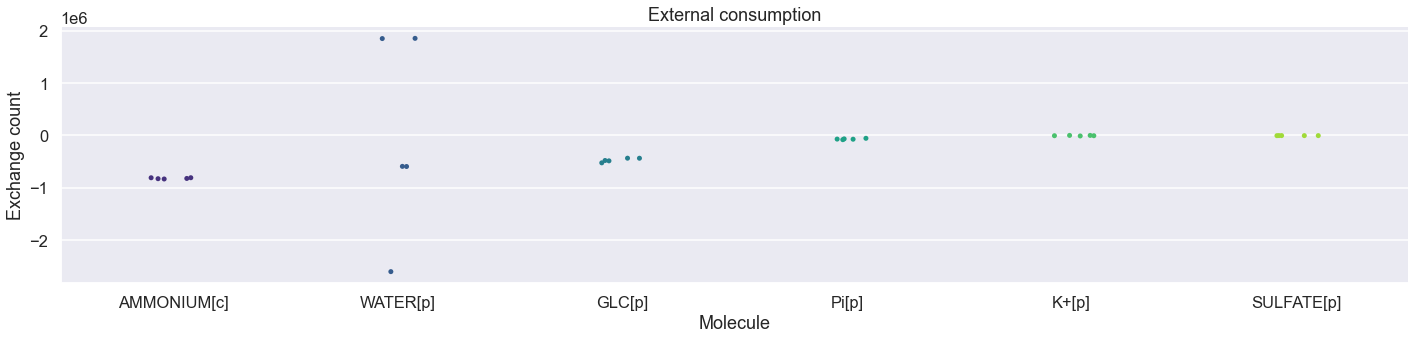

In [13]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External consumption')


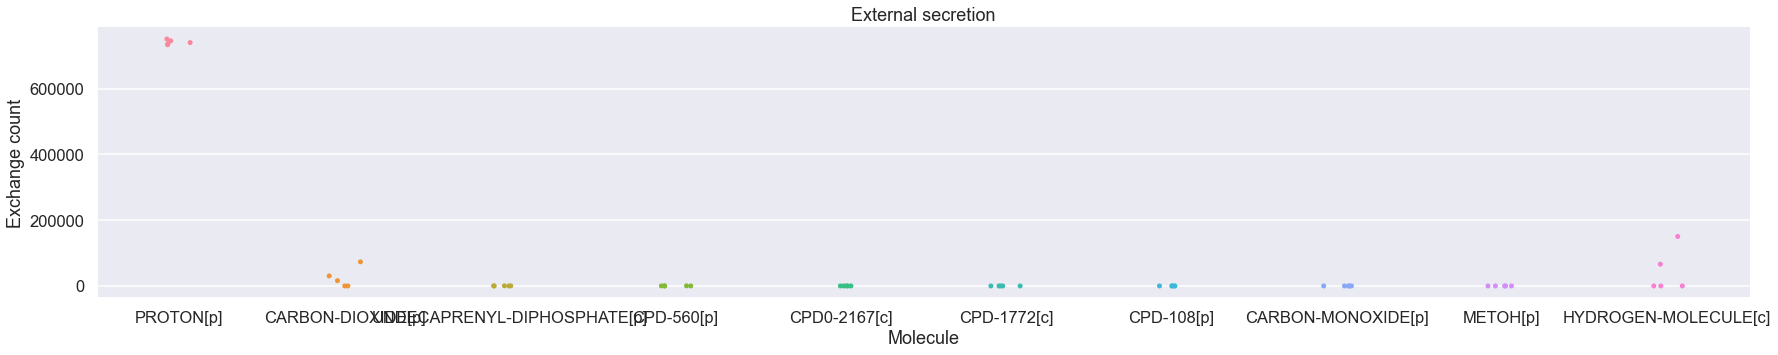

In [14]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:10].melt(var_name="Molecule", value_name="Exchange count"), aspect=5).set(title='External secretion')


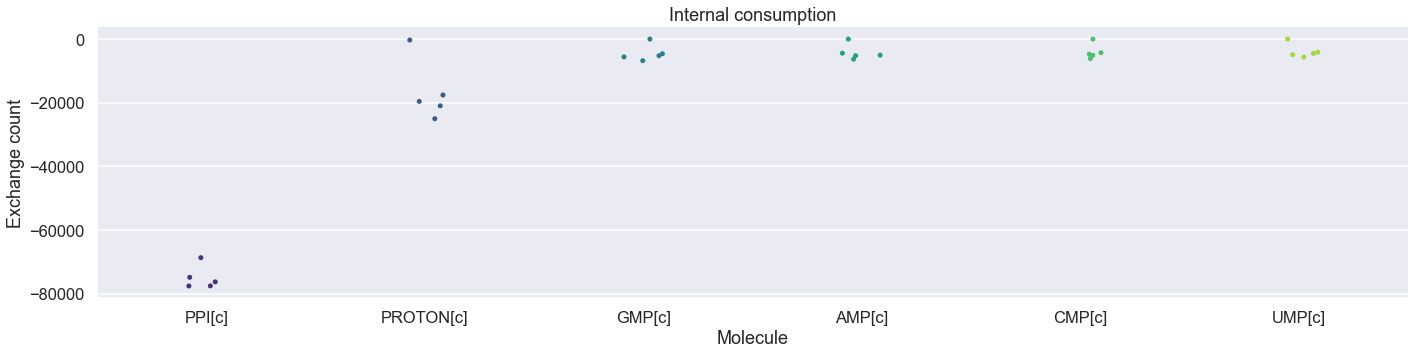

In [15]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal consumption')

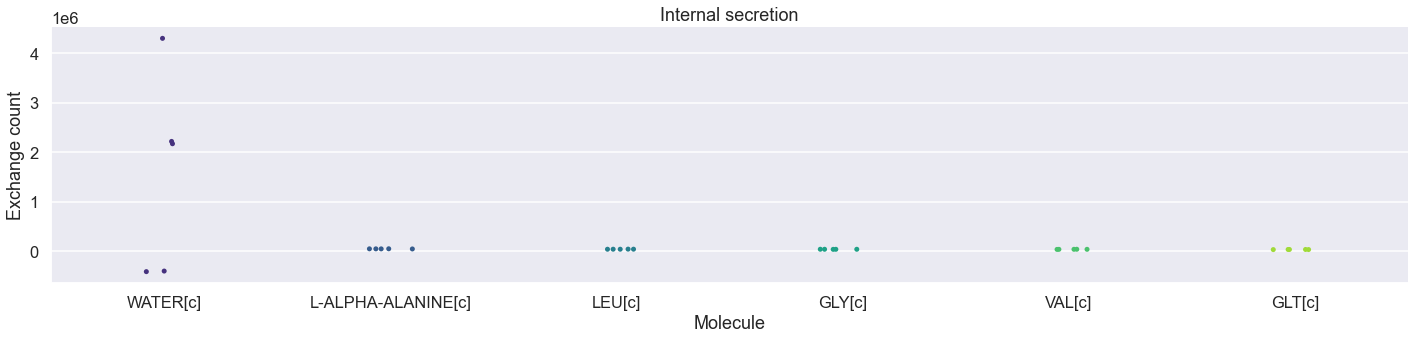

In [16]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal secretion')


# Meeting objectives

## Homeostatic

In [17]:
df1 = pd.DataFrame(fba['estimated_homeostatic_dmdt'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')
df1.head()

,index,timestep,update
0,2-3-DIHYDROXYBENZOATE[c],0,0
1,2-KETOGLUTARATE[c],0,0
2,2-PG[c],0,0
3,2K-4CH3-PENTANOATE[c],0,0
4,4-AMINO-BUTYRATE[c],0,0


In [18]:
df2 = pd.DataFrame(fba['target_homeostatic_dmdt'])
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df2.head()

,index,timestep,target
0,2-3-DIHYDROXYBENZOATE[c],0,0
1,2-KETOGLUTARATE[c],0,0
2,2-PG[c],0,0
3,2K-4CH3-PENTANOATE[c],0,0
4,4-AMINO-BUTYRATE[c],0,0


In [19]:
df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])
# df3[df3['timestep'] == 900].T
df3

df3['update'] = df3['update'].abs() 
df3['target'] = df3['target'].abs() 

df3['update'] = np.log10(df3['update'])
df3['target'] = np.log10(df3['target'])

df3 = df3.replace([np.inf, -np.inf], 0)

df3['diff'] = df3['target'] - df3['update']

df3.head()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,update,target,diff
0,2-3-DIHYDROXYBENZOATE[c],0,0.0,0.0,0.0
1,2-KETOGLUTARATE[c],0,0.0,0.0,0.0
2,2-PG[c],0,0.0,0.0,0.0
3,2K-4CH3-PENTANOATE[c],0,0.0,0.0,0.0
4,4-AMINO-BUTYRATE[c],0,0.0,0.0,0.0


In [20]:
df3_subset = df3[df3['timestep'].isin([0, 1, 2, 10, 24, 100])]

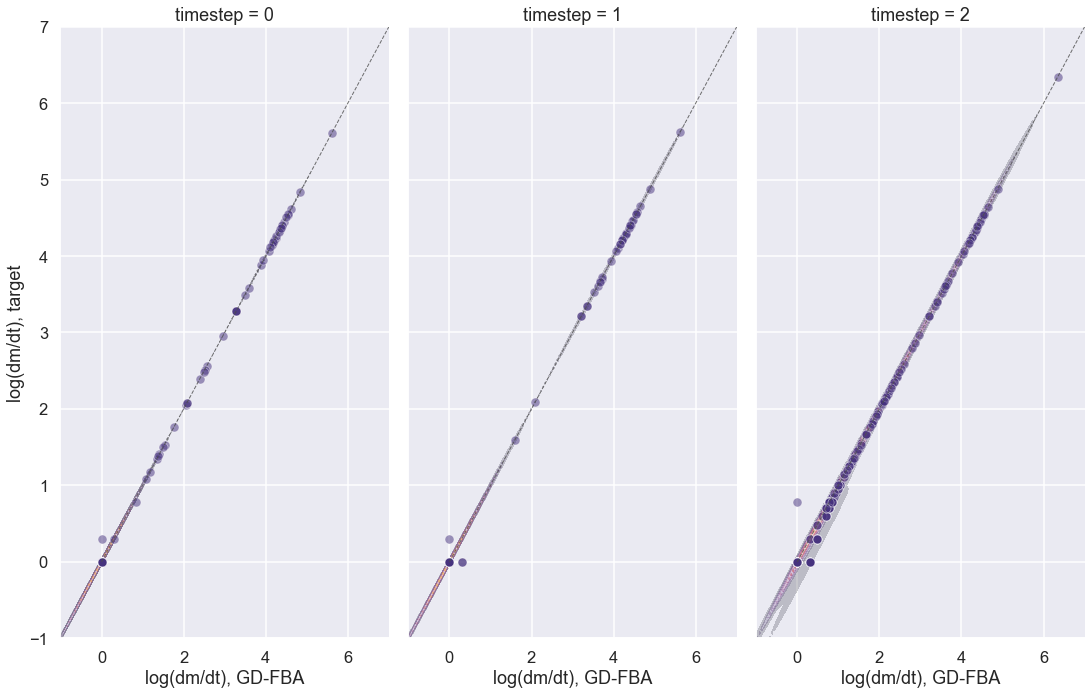

In [21]:
g = sns.FacetGrid(df3_subset, col="timestep", col_wrap=6, aspect=0.5, height=10, xlim=(-1,7), ylim=(-1,7))
g.map(sns.kdeplot, "update", "target", cmap="inferno", alpha=0.2, fill=True)
g.map(sns.scatterplot, "update", "target", alpha=0.5)
g.set_axis_labels("log(dm/dt), GD-FBA","log(dm/dt), target")

for ax in g.axes:
    ax.plot([0, 9], [0, 9], linewidth=1,  linestyle='--', color='.3', alpha=0.8)
    

plt.margins(0,0)

### Are the outliers a problem?

<AxesSubplot:>

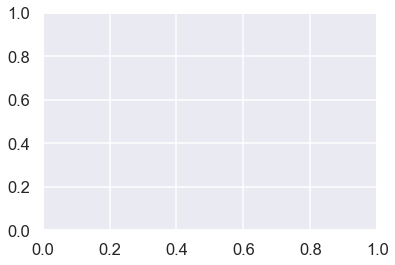

In [22]:
df4 = df3.loc[df3['timestep'] == 25].reset_index(drop=True)
outliers = list(df4.loc[df4['diff']>1, 'index'])

sns.histplot(x='diff', data=df4)

In [23]:
bulk.loc[35:40, outliers]

""


In [24]:
pd.DataFrame(fba['target_homeostatic_dmdt']).loc[35:40, outliers]

""


Doesn't look like they're going into negative at least. Are they being used? I would guess that they're just not incentivized enough to reach their target completely, since all the diffs are in the 10-100 range. Magnitudes smaller than their conc. 

## Futile cycling objective

In [25]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
cycle = fluxes.loc[:,['RXN0-7209-GLC//GLC.9.','RXN0-7247-GLC//GLC.9.']]
cycle.head()

cycle.columns = ['A->B', 'B->A']

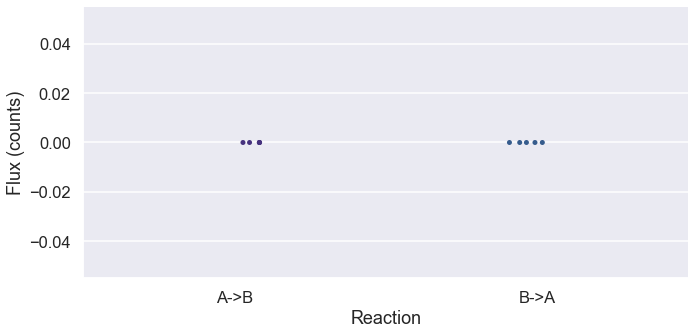

In [26]:
sns.catplot(y="Flux (counts)", x="Reaction", data=cycle.melt(var_name="Reaction", value_name="Flux (counts)"), aspect=2)

Could use improvement.

## Glucose uptake

In [27]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']


In [28]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
influx = fluxes.loc[:,glucose_transport_reactions]
influx.head()

influx.columns = ['PTS-1', 'PTS-2', 'PTS-3', 'DIF-1', 'DIF-2', 'DIF-3', 'DIF-4', 'DIF-5', 'DUP-1', 'DUP-2', 'DUP-3']

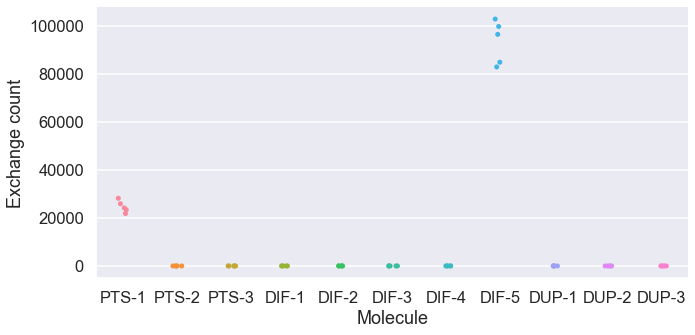

In [29]:
sns.catplot(y="Exchange count", x="Molecule", data=influx.melt(var_name="Molecule", value_name="Exchange count"), aspect=2)

Works as intended.

## Steady state objective

In [30]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Intermediate consumption')

KeyError: 'estimated_intermediate_dmdt'

In [31]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Intermediate production')

KeyError: 'estimated_intermediate_dmdt'

In [32]:
kinetic_substrates = agent['ecoli-metabolism-gradient-descent'].kinetic_constraint_substrates
kinetic_substrates[0:5]

KeyError: 'ecoli-metabolism-gradient-descent'

In [33]:
homeostatic_objective = list(agent['ecoli-metabolism-gradient-descent'].homeostatic_objective.keys())
homeostatic_objective[0:5]

KeyError: 'ecoli-metabolism-gradient-descent'

In [34]:
len(set(kinetic_substrates).intersection(set(homeostatic_objective)))

NameError: name 'kinetic_substrates' is not defined

In [35]:
len(kinetic_substrates)

NameError: name 'kinetic_substrates' is not defined

## Maintenance objective

In [36]:
maintenance = fba['estimated_fluxes']['maintenance_reaction']
maintenance_target = fba['maintenance_target']['maintenance_reaction']
sns.lineplot([i for i in range(len(maintenance))], maintenance)

KeyError: 'maintenance_reaction'

In [37]:
sns.lineplot([i for i in range(len(maintenance_target))], maintenance_target)

NameError: name 'maintenance_target' is not defined

## Kinetic objective

In [38]:
fba.keys()

dict_keys(['reactionFluxes', 'estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'estimated_exchange_dmdt', 'target_kinetic_fluxes', 'target_kinetic_bounds'])

In [39]:
df1 = pd.DataFrame(fba['target_kinetic_fluxes'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')

In [40]:
df4 = pd.DataFrame(fba['target_kinetic_bounds'])
df4 = df4.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df4 = pd.DataFrame(df4["target"].to_list(), columns=['lower', 'upper'])

df1 = df1.merge(df4, left_index=True, right_index=True)
df1.head()

,index,timestep,target,lower,upper
0,1.1.1.39-RXN,0,17723,17723,17723
1,1.1.1.83-RXN,0,490,490,490
2,1.13.11.16-RXN,0,33,0,66
3,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/N...,0,3367,2085,6016
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,311,9,1253


In [41]:
kinetic_rxns = list(fba['target_kinetic_fluxes'].keys())
df2 = pd.DataFrame(fba['estimated_fluxes']).loc[:, kinetic_rxns]
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')
df2

,index,timestep,update
0,1.1.1.39-RXN,0,0
1,1.1.1.83-RXN,0,0
2,1.13.11.16-RXN,0,0
3,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/N...,0,1683
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,0
...,...,...,...
2140,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UN...,4,60
2141,URA-PHOSPH-RXN,4,0
2142,UROGENIIISYN-RXN,4,5
2143,URPHOS-RXN__URPHOS-CPLX,4,18323


In [42]:
df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])
# df3[df3['timestep'] == 900].T
df3

for column in ["update", "target", "lower", "upper"]:
    df3[column] = df3[column].abs()
    df3[column] = np.log10(df3[column])

df3 = df3.replace([np.inf, -np.inf], 0)

df3['diff'] = df3['target'] - df3['update']

df3.head()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,target,lower,upper,update,diff
0,1.1.1.39-RXN,0,4.248537,4.248537,4.248537,0.000000,4.248537
1,1.1.1.83-RXN,0,2.690196,2.690196,2.690196,0.000000,2.690196
2,1.13.11.16-RXN,0,1.518514,0.000000,1.819544,0.000000,1.518514
3,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/N...,0,3.527243,3.319106,3.779308,3.226084,0.301159
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,2.492760,0.954243,3.097951,0.000000,2.492760


In [43]:
df3_subset = df3[df3['timestep'].isin([0, 1, 2, 10, 24, 100])]

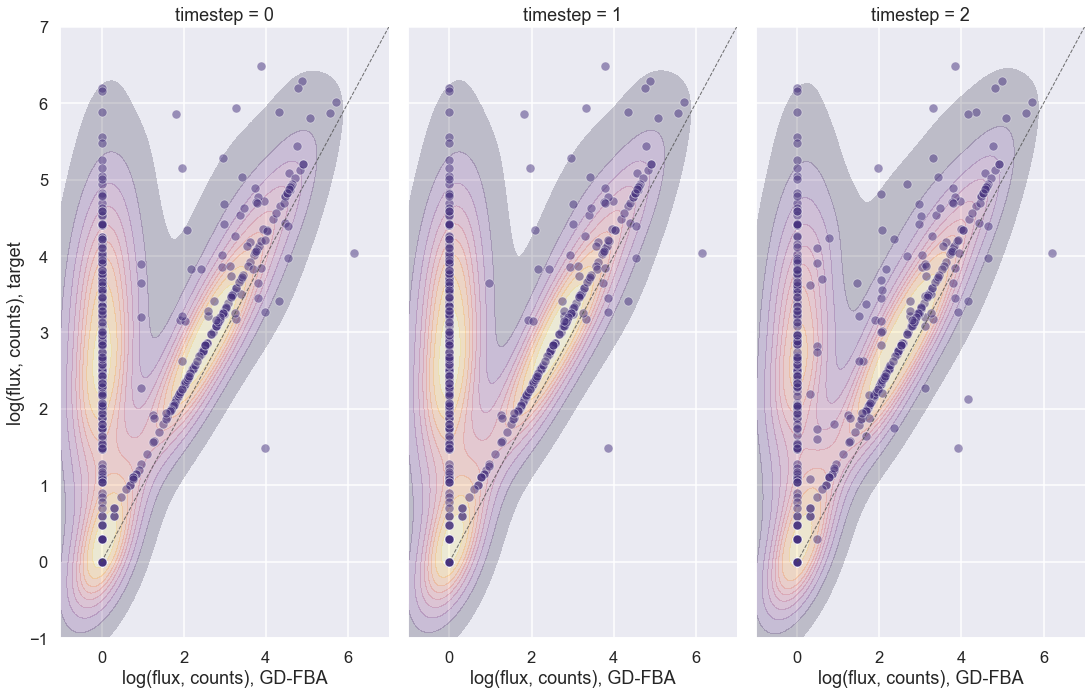

In [44]:
g = sns.FacetGrid(df3_subset, col="timestep", col_wrap=6, aspect=0.5, height=10, xlim=(-1,7), ylim=(-1,7))
g.map(sns.kdeplot, "update", "target", cmap="inferno", alpha=0.2, fill=True)
g.map(sns.scatterplot, "update", "target", alpha=0.5)
g.set_axis_labels("log(flux, counts), GD-FBA","log(flux, counts), target")

for ax in g.axes:
    ax.plot([0, 9], [0, 9], linewidth=1,  linestyle='--', color='.3', alpha=0.8)
    

plt.margins(0,0)

plt.savefig("out/fbagd/kinetics_high_weight_gd.jpg")

In [45]:
df3_subset = df3[df3['timestep'].isin([2])]

In [46]:
ranges = np.array(df3_subset.loc[:, ["lower","upper"]])
mid_dist = np.array([np.mean(ranges, axis=1), (ranges[:, 1] - ranges[:, 0])/2 + 0.1]).T

actual_flux = np.array(df3_subset["update"])
index = np.array(df3_subset["index"])

In [47]:
sort_index = mid_dist[:, 0].argsort()
sorted_fluxes = actual_flux[sort_index]
sorted_bars = mid_dist[sort_index,:]
sorted_index = index[sort_index]

In [48]:
sorted_fluxes[sorted_fluxes > 0] = sorted_fluxes[sorted_fluxes > 0] + 0.3

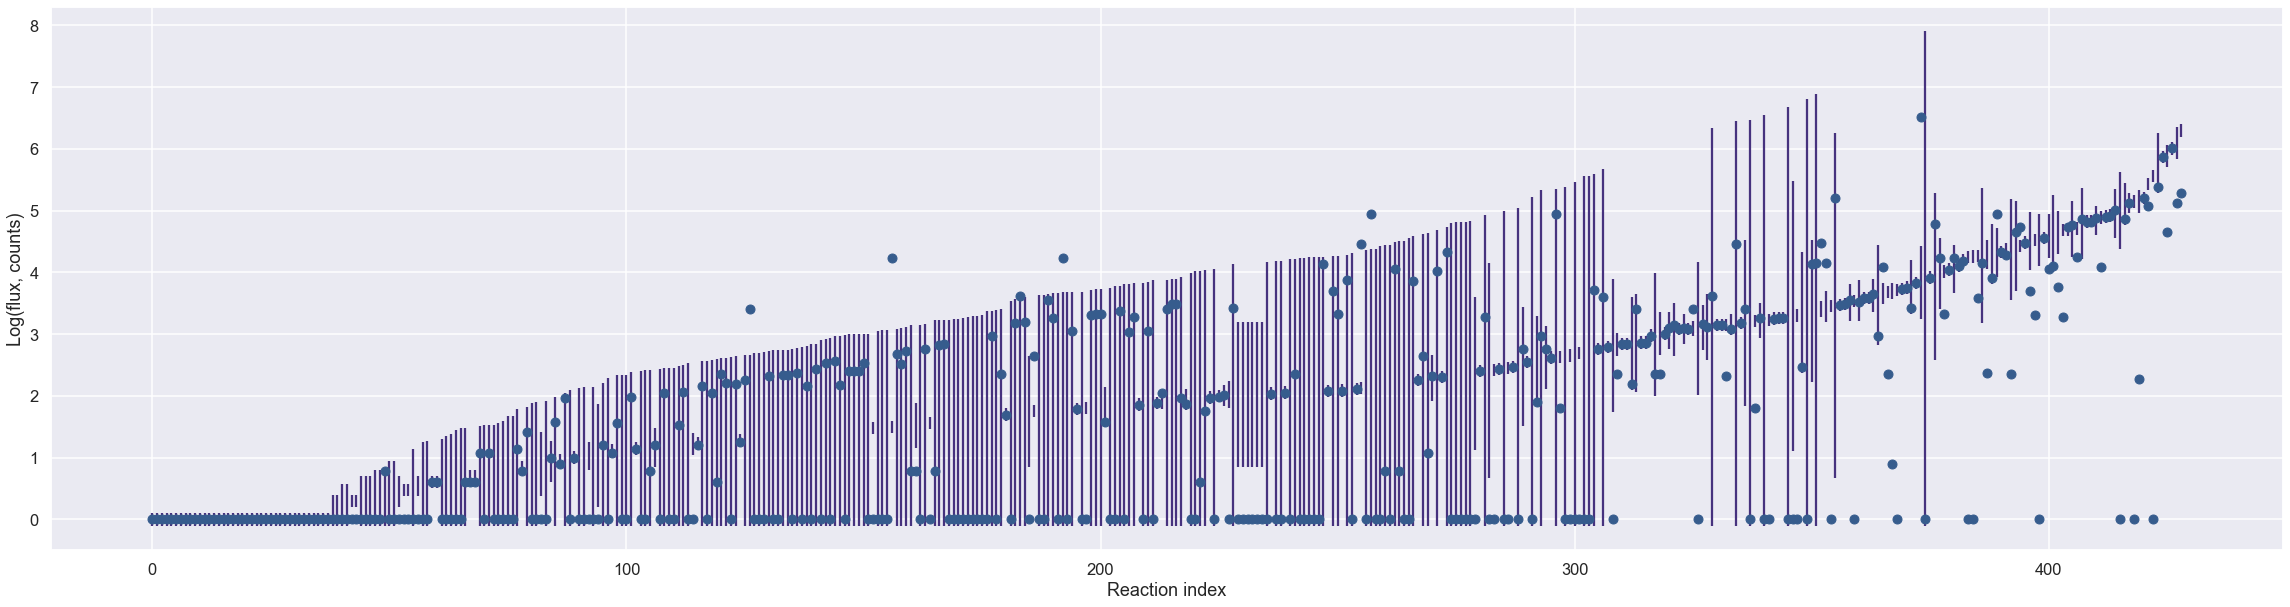

In [49]:
f, ax = plt.subplots(figsize=[40,10])

ax.errorbar(np.arange(0, len(sorted_fluxes)), sorted_bars[:, 0],  yerr=sorted_bars[:, 1], linestyle="none")
ax.plot(np.arange(0, len(sorted_fluxes)), sorted_fluxes, linestyle="none", marker='o')

plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')

plt.show()

In [59]:
sorted_top_fluxes = sorted_fluxes[sorted_bars[:,0] > 3]
sorted_top_bars = sorted_bars[sorted_bars[:,0] > 3]
sorted_top_index = sorted_index[sorted_bars[:,0] > 3]

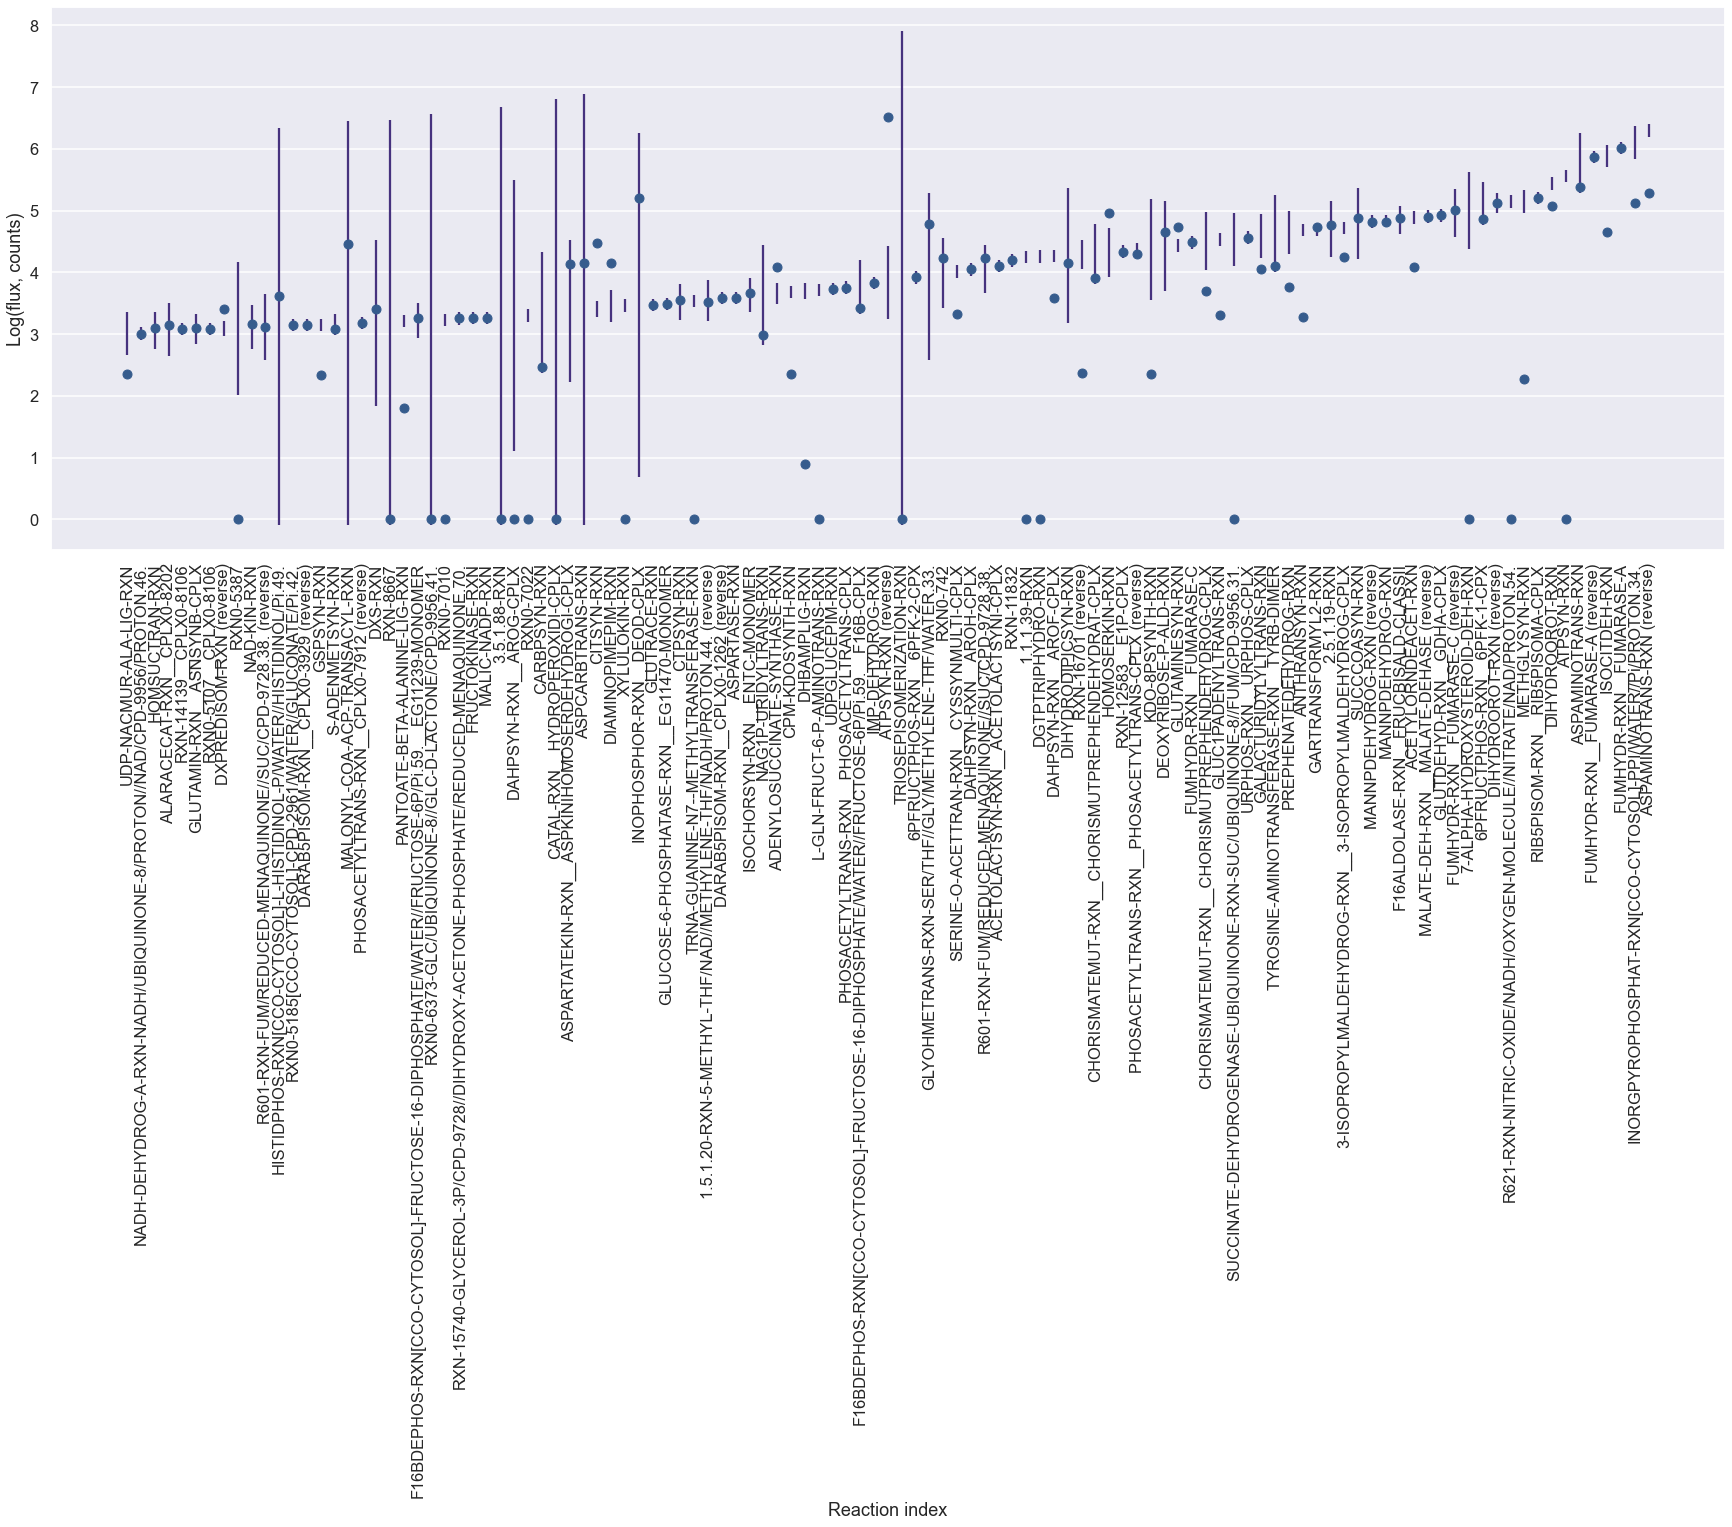

In [61]:
f, ax = plt.subplots(figsize=[30,10])

ax.errorbar(np.arange(0, len(sorted_top_fluxes)), sorted_top_bars[:, 0],  yerr=sorted_top_bars[:, 1], linestyle="none")
ax.plot(np.arange(0, len(sorted_top_fluxes)), sorted_top_fluxes, linestyle="none", marker='o')

plt.xlabel('Reaction index')
plt.ylabel('Log(flux, counts)')
plt.xticks(np.arange(0, len(sorted_top_fluxes), 1.0), labels=list(sorted_top_index), rotation=90)
plt.grid(axis='x')

plt.show()

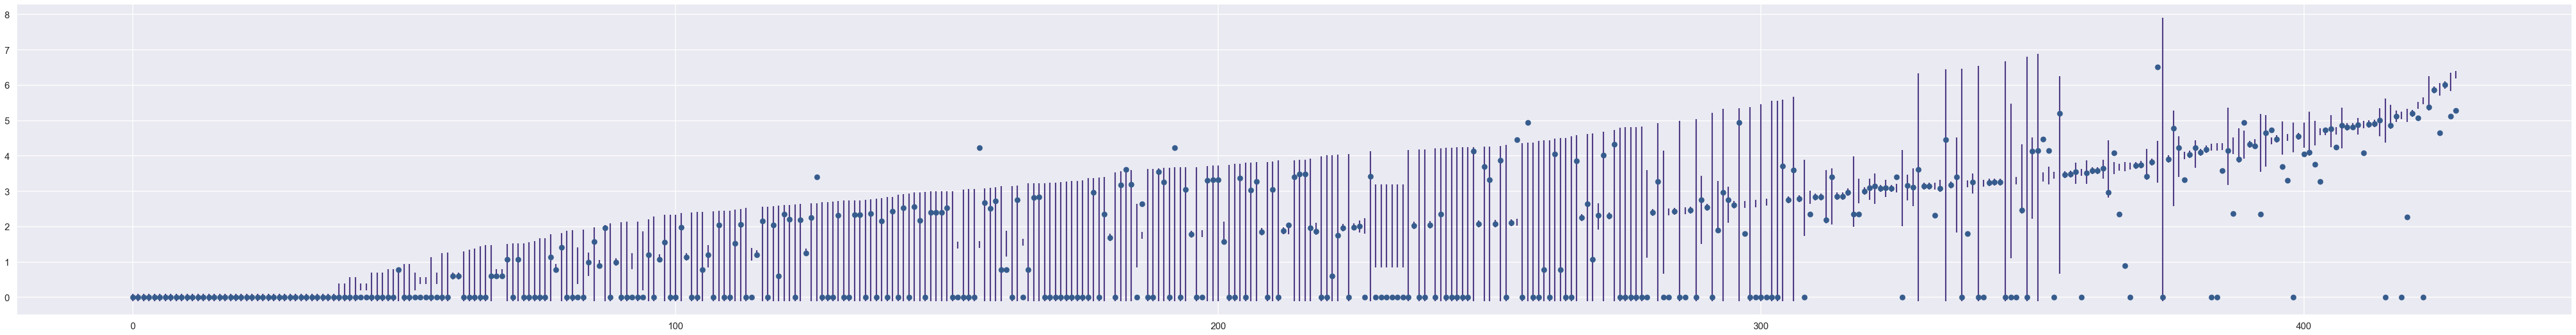

In [52]:
f, ax = plt.subplots(figsize=[80,10])

ax.errorbar(np.arange(0, len(df3_subset)), sorted_bars[:, 0],  yerr=sorted_bars[:, 1], linestyle="none")
ax.plot(np.arange(0, len(df3_subset)), sorted_fluxes, linestyle="none", marker='o')

plt.show()

### Investigating limit to kinetic fluxes

That's weird, there seems to be some limit around a hundred molecules per time step. 

In [53]:
weird_rxns = list(df3[(df3['timestep'].isin([4])) & (df3['diff'] > 1.5)]['index'])

In [54]:
len(weird_rxns)

139

In [55]:
for rxn in stoichiometry[:100]:
    if rxn['reaction id'] in weird_rxns:
        print(rxn['reaction id'], bulk.at[4, rxn['enzyme'][0]])

NameError: name 'stoichiometry' is not defined

Complexes are present.

Are intermediates preventing dmdt? But fba should balance out those? Maybe the targets are just way off.

In [56]:
# for rxn in stoichiometry:
#     if rxn['reaction id'] in weird_rxns:
#         target = fba['target_kinetic_fluxes'][rxn['reaction id']][4]
#         current = fba['estimated_fluxes'][rxn['reaction id']][4]
#         print(rxn['reaction id'],rxn['stoichiometry'],  f'{target} {current}', rxn['enzyme'][0],bulk.at[4, rxn['enzyme'][0]],'', sep='\n') #,bulk.at[4, rxn['enzyme'][0]]

In [57]:
MHPCHYDROL-RXN

NameError: name 'MHPCHYDROL' is not defined

In [58]:
intermediates = list(fba['estimated_intermediate_dmdt'].keys())

KeyError: 'estimated_intermediate_dmdt'

In [ ]:
for rxn in stoichiometry[:300]:
    if rxn['reaction id'] in weird_rxns:
        print(rxn['reaction id'], rxn['stoichiometry'])

In [ ]:
df3[(df3['timestep'].isin([4]))]

# Where's the large residuals coming from?

In [ ]:
df3['diff'] > 2

In [ ]:
df3['timestep'].isin([4])